# MBDoE for the rotary packed bed 

@Jialu Wang, Apr.7 2024

This notebook conducts MBDoE analysis to the RPB model (Co-current flow) provided by Ryan Hughes. It consists of three steps: 

1. Conduct MBDoE to one experiment
2. Conduct MBDoE for multiple experiments with a grid search way 
3. Optimize the MBDoE problem 

In [1]:
from pyomo.contrib.sensitivity_toolbox.sens import get_dsdp
import pyomo.environ as pyo
from RPB_model_cocurrent import *
import pickle
from pyomo.contrib.doe import DesignOfExperiments, MeasurementVariables, DesignVariables

## Create model

In [2]:
def create_model(mod=None, 
                 model_option="parmest"):
    """ This model creates and returns the RPB model 
    
    Arguments 
    ---------
    mod: Pyomo model. If None, a Pyomo concrete model is created 
    model_option: choose from 3 options in model_option:
        if "parmest": create a process model 
        if "stage1": create the global model  # NotImplemented
        if "stage2": add model variables and constraints for block # NotImplemented 
    """
    # need to create a model 
    if not mod:
        RPB = ConcreteModel()
    # takes an existed model 
    else:
        RPB = mod
    
    # fix model parameters to nominal values 
    parameter = {
    "DmCO2": 5.3e-5, 
    "C1": 2.562434e-12, 
    "hgx": 25 * 1e-3, 
    "Cp_sol": 1.457, 
    "rho_sol": 1144, 
    "delH_1": 98.76,
    "delH_2": 77.11, 
    "delH_3": 21.25
}
    # create conjugate models 
    RPB.ads = RPB_model(mode="adsorption", kaug=False, param_perturb=parameter)
    RPB.des = RPB_model(mode="desorption", kaug=False, param_perturb=parameter)

    # fix boundary conditions
    RPB.ads.P_in.fix(1.1)
    RPB.ads.Tg_in.fix()
    RPB.ads.y_in.fix()
    RPB.ads.P_out.fix(1.01325)

    RPB.des.P_in.fix(1.1)
    RPB.des.Tg_in.fix()
    RPB.des.y_in.fix()
    RPB.des.P_out.fix(1.01325)

    # connect rich stream
    # unfix inlet loading and temperature to the desorption section. (No mass transfer at boundaries so z=0 and z=1 need to remain fixed.)
    for z in RPB.des.z:
        if z!=0 and z!=1:
            RPB.des.qCO2_in[z].unfix()
            RPB.des.Ts_in[z].unfix()

    # add equality constraint equating inlet desorption loading to outlet adsorption loading. Same for temperature.
    @RPB.Constraint(RPB.des.z)
    def rich_loading_constraint(RPB,z):
        if z==0 or z==1:
            return Constraint.Skip
        else:
            return RPB.des.qCO2_in[z] == RPB.ads.qCO2[z,1]
    
    @RPB.Constraint(RPB.des.z)
    def rich_temp_constraint(RPB,z):
        if z==0 or z==1:
            return Constraint.Skip
        else:
            return 1e-2*RPB.des.Ts_in[z] == 1e-2*RPB.ads.Ts[z,1]


    # connect lean stream
    # unfix inlet loading to the adsorption section
    for z in RPB.ads.z:
        if z!=0 and z!=1:
            RPB.ads.qCO2_in[z].unfix()

    # add equality constraint equating inlet adsorption loading to outlet desorption loading
    @RPB.Constraint(RPB.ads.z)
    def lean_loading_constraint(RPB,z):
        if z==0 or z==1:
            return Constraint.Skip
        else:
            return RPB.des.qCO2[z,1] == RPB.ads.qCO2_in[z]


    # create Block init object
    init_obj = BlockTriangularizationInitializer()

    init_obj.config.block_solver_call_options = {"tee": True}
    # init_obj.config.block_solver_options = {"halt_on_ampl_error": "yes"}

    # turn on solids mass transfer (with the loadings connected at the rich and lean ends, solids mass transfer has to be turned on or no solution exists)
    RPB.ads.R_MT_solid = 1
    RPB.des.R_MT_solid = 1

    # now turn on the other equations using the homotopy routine

    variables_list = [
        RPB.ads.R_MT_gas,
        RPB.des.R_MT_gas,
        RPB.ads.R_MT_coeff,
        RPB.des.R_MT_coeff,
        RPB.ads.R_HT_ghx,
        RPB.des.R_HT_ghx,
        RPB.ads.R_HT_gs,
        RPB.des.R_HT_gs,
        RPB.ads.R_delH,
        RPB.des.R_delH,
    ]

    targets_list = [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
    ]

    # add a objective function for k_aug mode
    RPB.Obj = pyo.Objective(expr=0, sense=pyo.minimize)
    
    # if there is no existing model, the model needs to be returned
    if not mod:    
        return RPB


### Parameter

In [3]:
# parameter and nominal values 
parameter_dict = {
    "ads.C1": 2.562434e-12, 
     "des.C1": 2.562434e-12,
     "ads.hgx": 25 * 1e-3, 
      "des.hgx": 25 * 1e-3,
     "ads.delH_1": 98.76, 
     "des.delH_1": 98.76,
     "ads.delH_2": 77.11, 
    "des.delH_2": 77.11
}

### Measurements and their variances 

In [4]:
# read measurement variances 

# Each measurement has a variance; there are no covariances between measurements 
# file contains: [Nm * 1], Nm: # of measurements, each element is the variance of the corresponding measurement
file = open("./MO_QVs/Var_z3", "rb")
var_data = pickle.load(file)
file.close()

# read a MO solution file
# file contains: [Nm*Nm], sol_data[i,i] is a binary variable showing if measurement i is chosen 
file = open('Sep17_2000_a', 'rb')
sol_data = pickle.load(file)
file.close()

# read file names 
# file contains: [Nm*1], each element is the name of the corresponding measurement 
file = open("./MO_QVs/name_z3", 'rb')
name_data = pickle.load(file)
file.close()

# sol_idx contains the index of the chosen measurements 
sol_idx = [] 

# loop over all measurements
for i in range(len(sol_data)):
    # if this measurement is chosen, add its index to sol_idx
    if sol_data[i][i] == 1:
        sol_idx.append(i)

# According to the chosen index, we can read the variance 
var_list = [var_data[i] for i in sol_idx]

# According to the chosen name, we can print the name 
# TODO: a function to translate the measurement names to their names used in the model 
name_list = [name_data[i] for i in sol_idx]

In [5]:
# ax5: 0.1325, rot 0: 0.01
# ax 20: 0.5, rot 1: 0.5
# ax 40: 0.99333, rot 2: 0.99333
# solid: 
# ax0: 0.01, rot1:0.091667
# ax1: 0.5, rot5: 0.5
# ax2: 0.99333, rot10:0.99333

In [6]:
# Create the measurement class 
measure_class = MeasurementVariables()
# Provide the name of measurements used in the model 
variable_names = ['ads.y[CO2,0.1325,0.01]', 
                  'des.y[CO2, 0.5, 0.01]',
                  'ads.y[CO2,0.5,0.99333]',
                  'des.y[CO2,0.1325,0.99333]',
                  
                  'ads.C[CO2,0.1325,0.01]', 
                  'ads.C[CO2,0.5,0.99333]',
                  'des.C[CO2,0.1325,0.99333]',
                  
                  'des.C[N2,0.1325,0.01]',
                  'des.C[N2,0.5,0.01]',
                  'des.C[N2,0.1325,0.5]', 
                  'des.C[N2,0.99333,0.5]',
                  'des.C[N2,0.1325, 0.99333]',
                  'des.C[N2,0.5, 0.99333]',
                  
                 'ads.qCO2[0.01,0.091667]', 
                 'ads.qCO2[0.01,0.5]', 
                 'des.qCO2[0.01,0.5]', 
                 'des.qCO2[0.01,0.99333]', 
                    
                  'ads.ytheta[0.01, 0.5]',
                  'des.ytheta[0.01, 0,091667]',
                  'des.ytheta[0.01, 0,5]'
                 ]


# create variables, and provide their variances 
measure_class.set_variable_name_list(variable_names, variance = var_list)
# provide variance 
measure_class.variance.update(zip(variable_names, var_list))

print(measure_class.variance)

{'ads.y[CO2,0.1325,0.01]': 2.835054601637036e-09, 'des.y[CO2, 0.5, 0.01]': 1.1774765892795347e-08, 'ads.y[CO2,0.5,0.99333]': 8.542994902996853e-09, 'des.y[CO2,0.1325,0.99333]': 7.069908349632278e-09, 'ads.C[CO2,0.1325,0.01]': 3.5191531629226262e-06, 'ads.C[CO2,0.5,0.99333]': 1.0310122441060627e-05, 'des.C[CO2,0.1325,0.99333]': 7.907769162338885e-06, 'des.C[N2,0.1325,0.01]': 1.0927713041181694e-07, 'des.C[N2,0.5,0.01]': 1.1785043512562482e-07, 'des.C[N2,0.1325,0.5]': 1.1133738075978374e-07, 'des.C[N2,0.99333,0.5]': 1.0111117257221078e-07, 'des.C[N2,0.1325, 0.99333]': 1.0998024257586116e-07, 'des.C[N2,0.5, 0.99333]': 1.0452240616075246e-07, 'ads.qCO2[0.01,0.091667]': 5.234500115478307e-06, 'ads.qCO2[0.01,0.5]': 9.569804856628408e-05, 'des.qCO2[0.01,0.5]': 0.00010287066053640888, 'des.qCO2[0.01,0.99333]': 4.725248683216949e-06, 'ads.ytheta[0.01, 0.5]': 8.447956175428945e-08, 'des.ytheta[0.01, 0,091667]': 7.217063246902327e-09, 'des.ytheta[0.01, 0,5]': 1.5353934421260013e-08}


In [7]:
# create design variable object

design_gen = DesignVariables()
design_gen.set_variable_name_list(['ads.Tg_in', 'des.Tg_in'])

## Solve a square MBDoE problem with k_aug

In [8]:
# choose from 'sequential_finite', 'direct_kaug'
sensi_opt = "direct_kaug"
#sensi_opt = "sequential_finite"

# Define experiments
design_names = design_gen.variable_names
exp1 = [90+273, 120+273]
# create experiment
exp1_design_dict = dict(zip(design_names, exp1))
# update design object
design_gen.update_values(exp1_design_dict)

In [9]:
# create DoE object
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model)

# analyze a square MBDoE problem
result = doe_object.compute_FIM(mode=sensi_opt, 
                                FIM_store_name = 'dynamic.csv', 
                                read_output=None,
                                scale_nominal_param_value=True)


result.result_analysis()

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a co

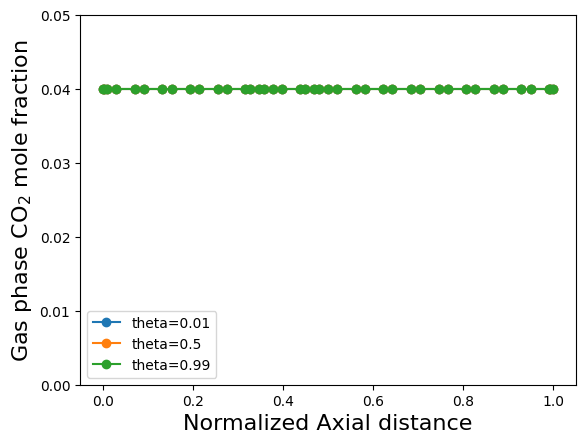

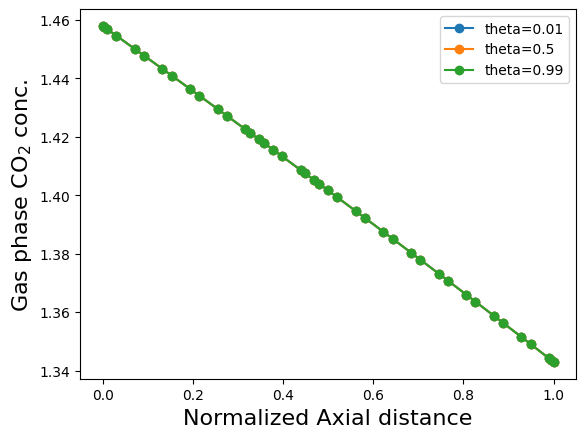

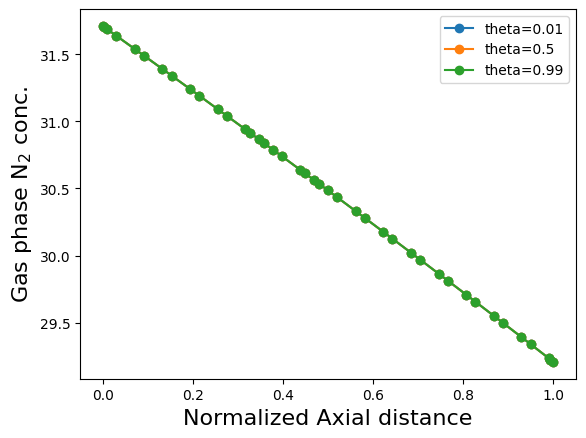

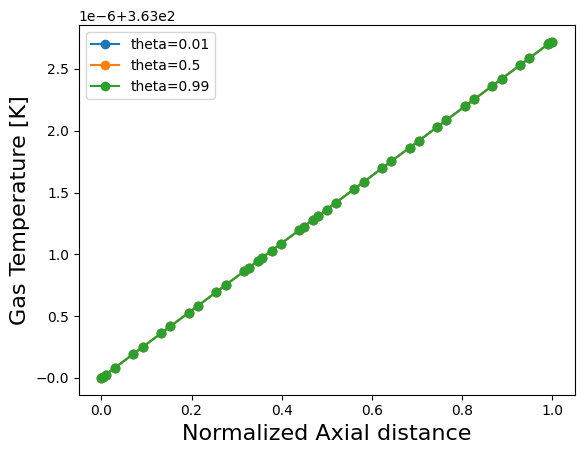

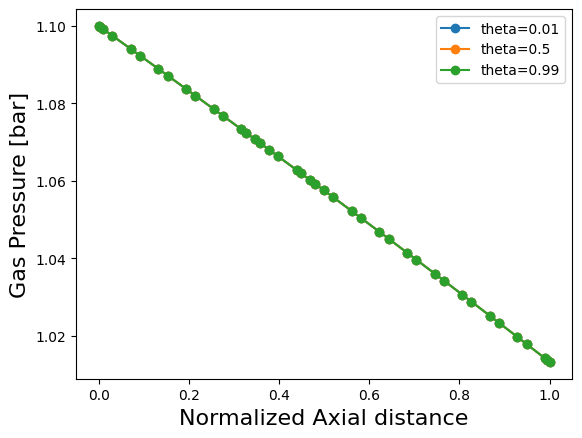

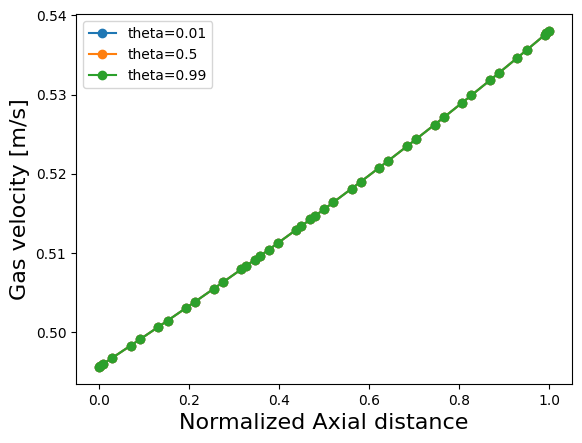

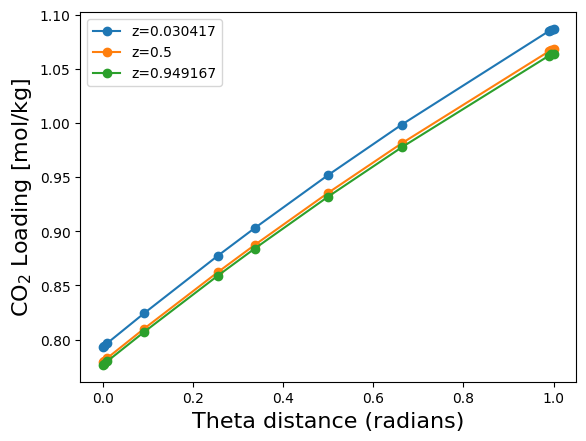

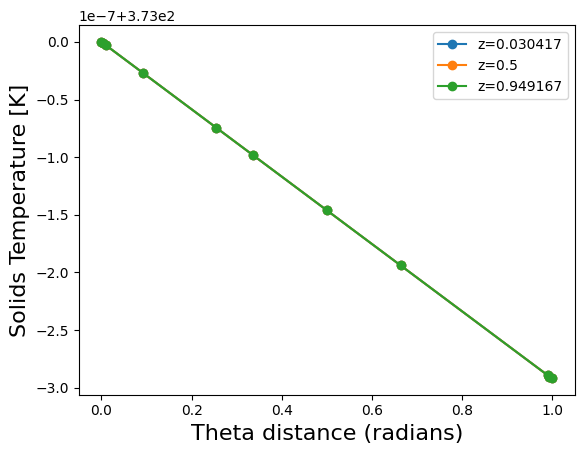

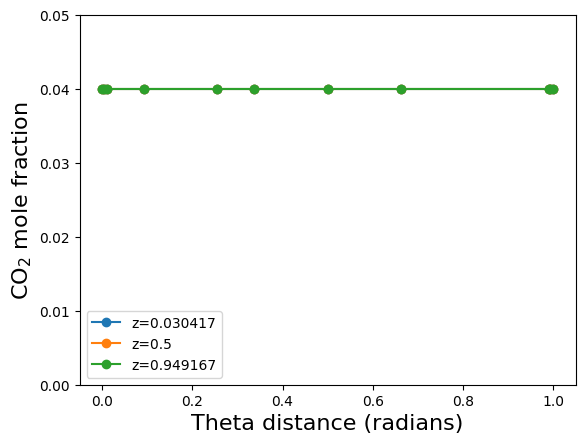

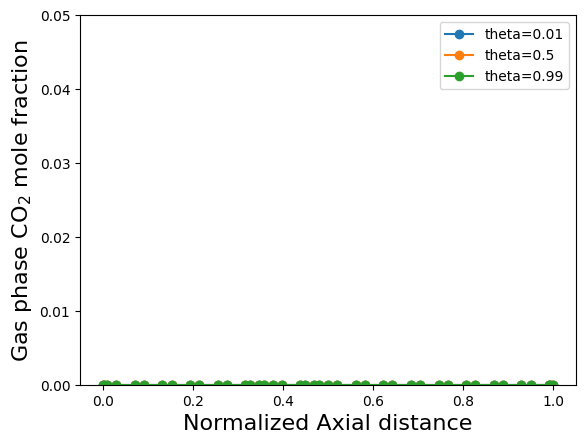

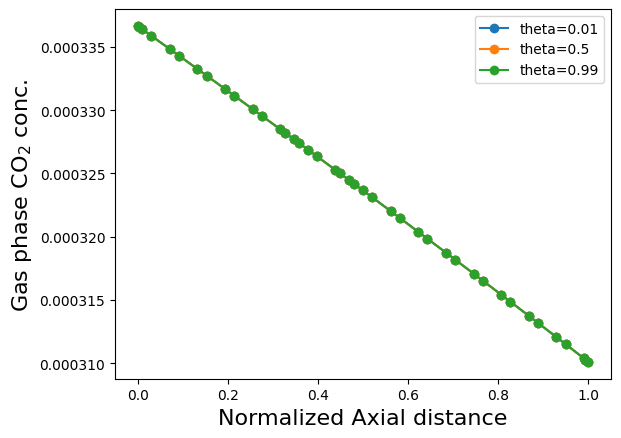

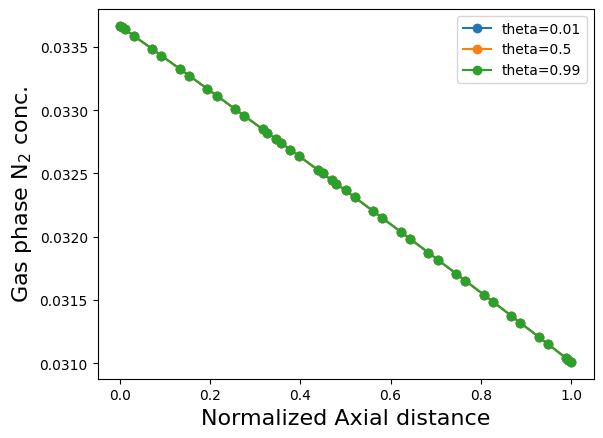

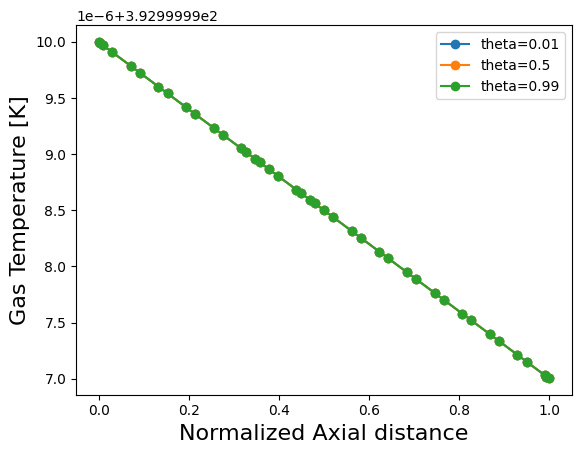

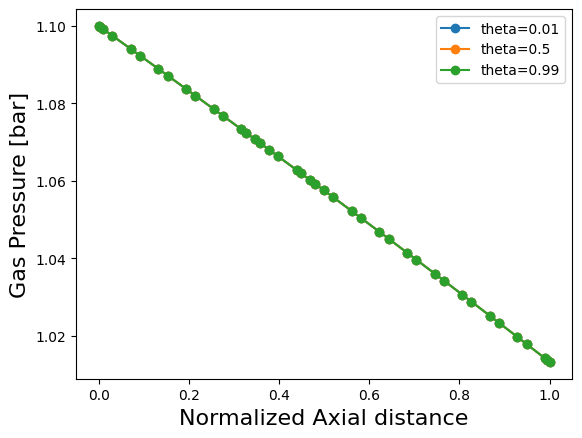

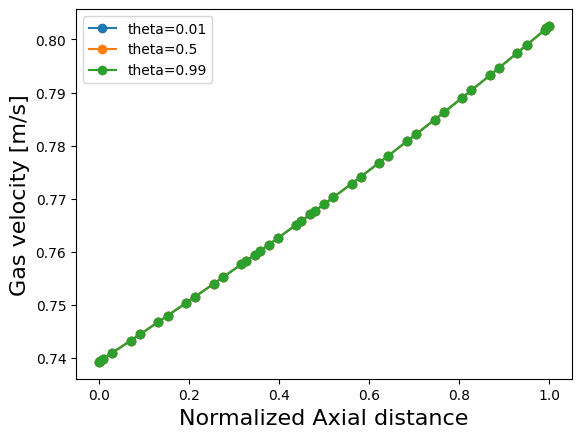

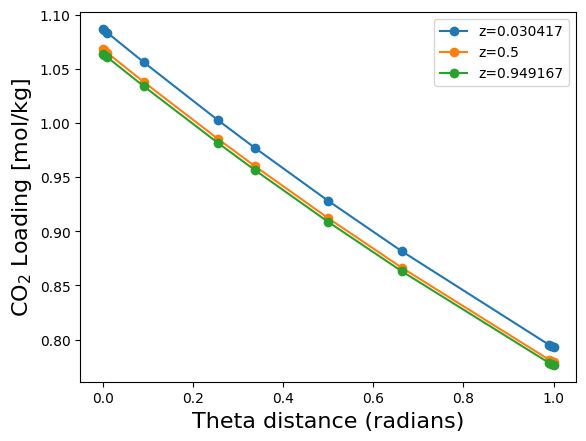

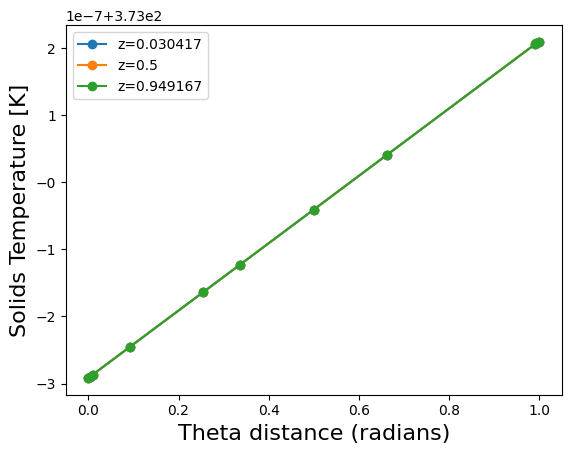

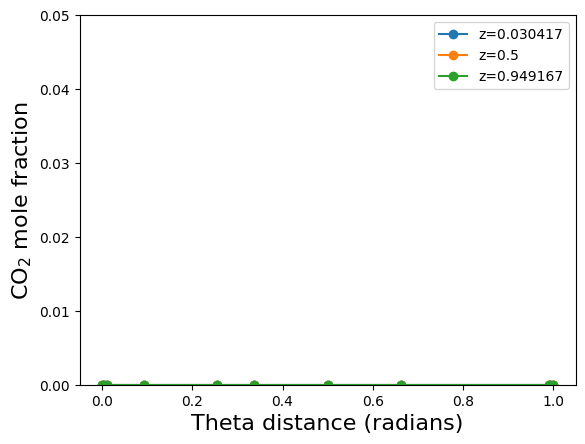

In [10]:
# plotting results

measure_ads = plotting_and_saving(doe_object.mod.ads)

# and/or 

measure_des = plotting_and_saving(doe_object.mod.des)

In [11]:
#print(doe_object.jac)

In [12]:
## Results summary
print("======Results Summary======")
print("Four design criteria log10() value:")
print("A-optimality:", np.log10(result.trace))
print("D-optimality:", np.log10(result.det))
print("E-optimality:", np.log10(result.min_eig))
print("Modified E-optimality:", np.log10(result.cond))
print(result.FIM)
print(np.linalg.eig(result.FIM))

======Results Summary======
Four design criteria log10() value:
A-optimality: -8.668934075036065
D-optimality: -194.18659869906935
E-optimality: nan
Modified E-optimality: nan
[[ 1.96087695e-14 -2.42230857e-14 -4.50714801e-26  1.48130211e-27
   4.32646343e-15  2.39149829e-17 -5.51647188e-15  1.20616743e-32]
 [-2.42230857e-14  3.00828130e-14  5.57749009e-26 -2.35314791e-27
  -5.36798377e-15 -2.98862252e-17  6.85924073e-15 -1.53889491e-32]
 [-4.50714801e-26  5.57749009e-26  7.90567115e-34  1.85342656e-35
   3.21998289e-24  6.73523801e-26 -3.15560300e-24  4.32183383e-41]
 [ 1.48130211e-27 -2.35314791e-27  1.85342656e-35  9.15769084e-32
   2.46849481e-21  3.93207768e-23 -4.58272105e-21  6.59202136e-38]
 [ 4.32646343e-15 -5.36798377e-15  3.21998289e-24  2.46849481e-21
   1.16757781e-09  2.50325139e-11 -1.02956968e-09  1.38298965e-26]
 [ 2.39149829e-17 -2.98862252e-17  6.73523801e-26  3.93207768e-23
   2.50325139e-11  5.38837043e-13 -2.16938594e-11  2.90718697e-28]
 [-5.51647188e-15  6.85924

/tmp/ipykernel_48942/4180964335.py:6: RuntimeWarning: invalid value encountered in log10
  print("E-optimality:", np.log10(result.min_eig))
/tmp/ipykernel_48942/4180964335.py:7: RuntimeWarning: invalid value encountered in log10
  print("Modified E-optimality:", np.log10(result.cond))


## Exploratory analysis

In [13]:
# provide grid search ranges
design_ranges = {
    "ads.Tg_in": [90+273, 95+273],
    "des.Tg_in": [110+273, 120+273]
}

# choose k_aug 
sensi_opt = "direct_kaug"

In [14]:
# Create doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(
    parameter_dict,  # dictionary of parameters
    design_gen,  # design variable
    measure_class,  # measurement variable
    create_model,  # model
    #prior_FIM=prior_pass,  # FIM of prior experiment
)

# Grid search
all_fim = doe_object.run_grid_search(
    design_ranges,  # range of design variables
    mode=sensi_opt,  # solver option for sensitivity
)

INFO: =======Iteration Number: 1 =====
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
INFO: elapsed time: 60.2
INFO: This is run 1 out of 4.
INFO: The code has run  60.18920349700056 seconds.
INFO: Estimated remaining time:  60.18920349700056 seconds
INFO: =======Iteration Number: 2 =====
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
component keys that are not exported as part of the NL file.  Skipping.
com

In [15]:
# extract the FIM criteria 

all_fim.extract_criteria()
print(all_fim.store_all_results_dataframe)

   ads.Tg_in  des.Tg_in             A              D             E  \
0      363.0      383.0  7.567880e+09  1.764723e-152 -5.780318e-32   
1      363.0      393.0  7.567936e+09  1.042331e-157 -5.730616e-30   
2      368.0      383.0  7.415537e+09  1.162774e-137  1.484593e-59   
3      368.0      393.0  7.415593e+09  1.275868e-160 -1.686694e-34   

             ME  
0 -1.307588e+41  
1 -1.318939e+39  
2  4.988657e+68  
3 -4.390946e+43  


/home/parallels/.local/lib/python3.8/site-packages/pyomo/contrib/doe/result.py:663: RuntimeWarning: invalid value encountered in log10
  hes_e = np.log10(self.cri_e)
/home/parallels/.local/lib/python3.8/site-packages/pyomo/contrib/doe/result.py:665: RuntimeWarning: invalid value encountered in log10
  hes_e2 = np.log10(self.cri_e_cond)


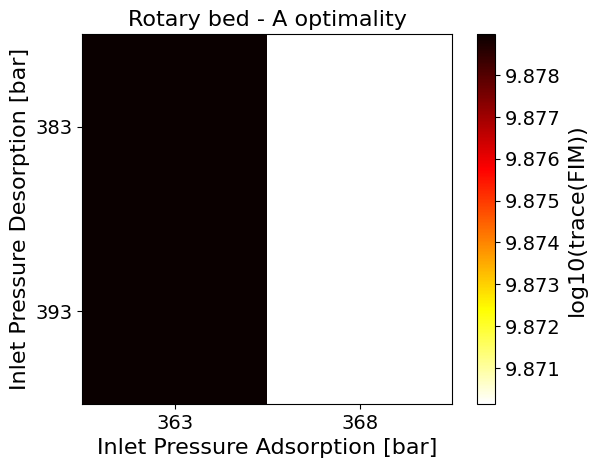

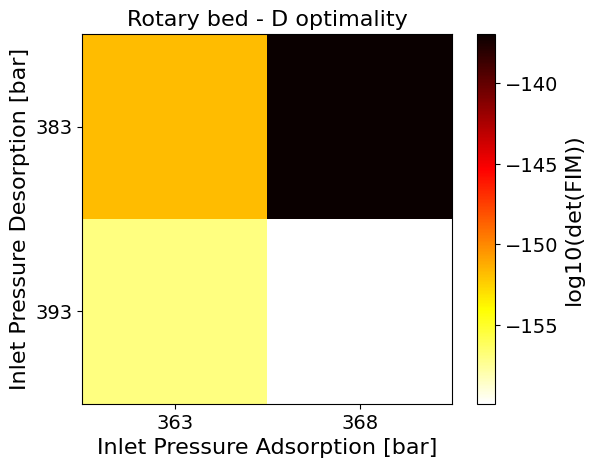

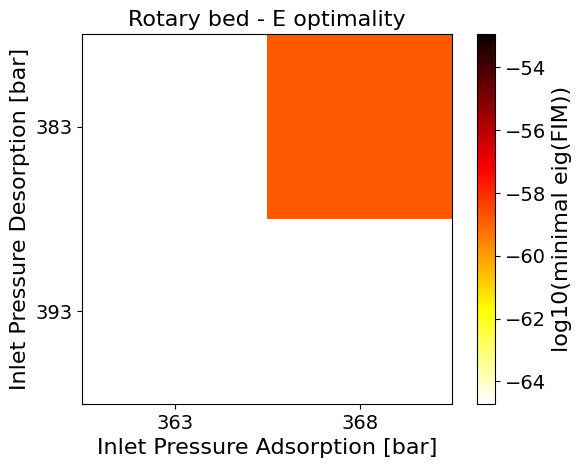

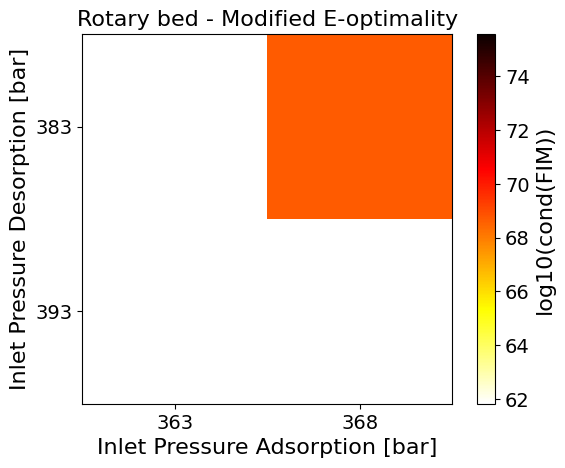

In [16]:
# draw figures

fixed = {}
all_fim.figure_drawing(
fixed, ["ads.Tg_in", "des.Tg_in"], "Rotary bed",
    "Inlet Pressure Adsorption [bar]",
"Inlet Pressure Desorption [bar]")

## Structured programming 

In [17]:
# Define experiments
design_names = design_gen.variable_names
exp1 = [90+273, 120+273]
exp1_design_dict = dict(zip(design_names, exp1))

design_gen.update_values(exp1_design_dict)

In [18]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model)

square_result, optimize_result = doe_object.stochastic_program(
                                if_optimize=True, 
                                if_Cholesky=True,  
                                scale_nominal_param_value=True,
                                objective_option="det")


ERROR: Constructing component 'block' from data=None failed:
        AttributeError: 'ScalarParam' object has no attribute 'fix'


AttributeError: 'ScalarParam' object has no attribute 'fix'